In [ ]:
# torch.nn.functional中有很多功能，后续会常用。那么什么是用nn.Module，什么时候用nn.functional呢
# 一般情况下，如果 模型有可学习的参数，最好用nn.Module，其他情况用nn.functional更简单一些
# MSB:可以认为是大端存储
# python中的...省略号,表示索引操作时省略冒号 a[:,:,1] = a[...,1]

In [ ]:
'''
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  10000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  10000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).
'''

(28, 28) ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


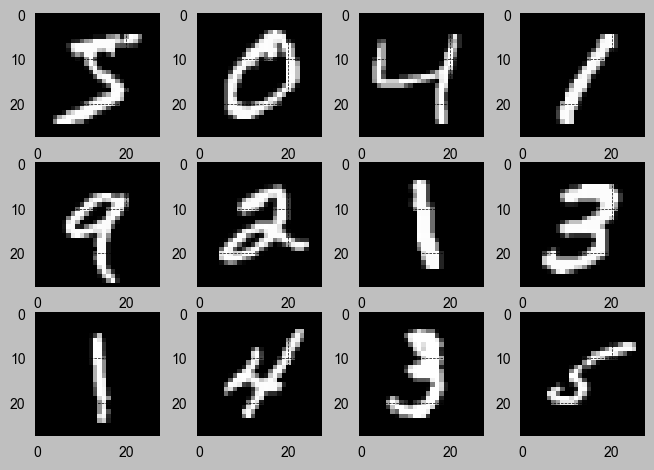

In [37]:
%matplotlib inline
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt

mnist = {
    'trainset'  :'d:/GitRepos/data/MNIST/train-images-idx3-ubyte.gz',
    'trainlabel':'d:/GitRepos/data/MNIST/train-labels-idx1-ubyte.gz',
    'testset'   :'d:/GitRepos/data/MNIST/t10k-images-idx3-ubyte.gz',
    'testlabel' :'d:/GitRepos/data/MNIST/t10k-labels-idx1-ubyte.gz'
}
m_header = {
    'magic' :0,
    'cnt'   :0,
    'rows'  :0,
    'cols'  :0
}
m_labelheader = {
    'magic'  :0,
    'itemNum':0
}

def get_header(path : str,header_fmt : str):
    offset = 0
    # fmt = '>{}i'.format(head_size)
    with gzip.open(path) as f:
        bytescontent = f.read()
        h_list = [x for x in struct.unpack_from(header_fmt,bytescontent,offset=offset)]
        keys   = [k for k in m_header.keys()]
        header = dict(zip(keys,h_list))
    return header

# offset : starting position
# format : asigning size of bytes
def image_loader_idx(path : str,header_fmt : str,header : dict,yield_size : int):
    # use struct.calcsize() to get the correct offset caused by aligning
    offset_head = struct.calcsize(header_fmt)
    size_image = header['rows'] * header['cols']
    fmt = '>{}B'.format(size_image)
    with gzip.open(path) as f:
        bindata = f.read()
        images_list = (np.array(struct.unpack_from(fmt,bindata,offset=struct.calcsize(fmt)*i + offset_head)).reshape(header['rows'],header['cols']) for i in range(yield_size))
    return images_list

def label_loader_idx(path : str,header_fmt : str,yield_size : int):
    offset_head = struct.calcsize(header_fmt)
    fmt = '>1B'
    with gzip.open(path) as f:
        bindata = f.read()
        labels_list = (struct.unpack_from(fmt,bindata,offset=offset_head + struct.calcsize(fmt*i)) for i in range(yield_size))
    return labels_list

m_header = get_header(path=mnist['trainset'],header_fmt='>4i')
m_labelheader = get_header(path=mnist['trainlabel'],header_fmt='>2i' )

image_loader = image_loader_idx(path=mnist['trainset'],header_fmt='>4i',header=m_header,yield_size=100)

# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
# print(list(image_loader)[0].shape, plt.style.available)

plt.style.use('grayscale')
fig, axs = plt.subplots(nrows=3,ncols=4)
for ax in axs:
    for a in ax:
        a.imshow(next(image_loader))



In [ ]:
"""
@author: monitor1379 
@contact: yy4f5da2@hotmail.com
@site: www.monitor1379.com

@version: 1.0
@license: Apache Licence
@file: mnist_decoder.py
@time: 2016/8/16 20:03

对MNIST手写数字数据文件转换为bmp图片文件格式。
数据集下载地址为http://yann.lecun.com/exdb/mnist。
相关格式转换见官网以及代码注释。

========================
关于IDX文件格式的解析规则：
========================
THE IDX FILE FORMAT

the IDX file format is a simple format for vectors and multidimensional matrices of various numerical types.
The basic format is

magic number
size in dimension 0
size in dimension 1
size in dimension 2
.....
size in dimension N
data

The magic number is an integer (MSB first). The first 2 bytes are always 0.

The third byte codes the type of the data:
0x08: unsigned byte
0x09: signed byte
0x0B: short (2 bytes)
0x0C: int (4 bytes)
0x0D: float (4 bytes)
0x0E: double (8 bytes)

The 4-th byte codes the number of dimensions of the vector/matrix: 1 for vectors, 2 for matrices....

The sizes in each dimension are 4-byte integers (MSB first, high endian, like in most non-Intel processors).

The data is stored like in a C array, i.e. the index in the last dimension changes the fastest.
"""

import numpy as np
import struct
import matplotlib.pyplot as plt

# 训练集文件
train_images_idx3_ubyte_file = '../../data/mnist/bin/train-images.idx3-ubyte'
# 训练集标签文件
train_labels_idx1_ubyte_file = '../../data/mnist/bin/train-labels.idx1-ubyte'

# 测试集文件
test_images_idx3_ubyte_file = '../../data/mnist/bin/t10k-images.idx3-ubyte'
# 测试集标签文件
test_labels_idx1_ubyte_file = '../../data/mnist/bin/t10k-labels.idx1-ubyte'


def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print '魔数:%d, 图片数量: %d张, 图片大小: %d*%d' % (magic_number, num_images, num_rows, num_cols)

    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print '已解析 %d' % (i + 1) + '张'
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数和标签数
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print '魔数:%d, 图片数量: %d张' % (magic_number, num_images)

    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print '已解析 %d' % (i + 1) + '张'
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):
    """
    TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):
    """
    TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)


def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):
    """
    TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  10000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_test_labels(idx_ubyte_file=test_labels_idx1_ubyte_file):
    """
    TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  10000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)




def run():
    train_images = load_train_images()
    train_labels = load_train_labels()
    # test_images = load_test_images()
    # test_labels = load_test_labels()

    # 查看前十个数据及其标签以读取是否正确
    for i in range(10):
        print train_labels[i]
        plt.imshow(train_images[i], cmap='gray')
        plt.show()
    print 'done'

if __name__ == '__main__':
    run()
